## Generate an initial optimized structure

In [4]:
smiles = "[CH2]C=O"

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

import sys

sys.path.append("../src/protopilot")

from protopilot.io import optimize

par_dir = optimize.write(
    smiles_string=smiles,
)

mol = Chem.MolFromSmiles(smiles)
img = Draw.MolToImage(
    mol,
    molsPerRow=1,
    subImgSize=(200, 200),
)

display(img)

Copy the bash command and run it in the terminal to perform the optimization.
Make sure to check that the structure is correct!


FileExistsError: Directory /home/tns97255/C5O-Kinetics/calc/_CH2_CdblO/Optimization/run already exists.

## Define the transition state smiles string and the path to the optimized structure preceding the transition

In [ ]:
from pathlib import Path
import sys

sys.path.append(str(Path.home() / "C5O-Kinetics"))
import altair as alt
import numpy as np
import pandas as pd
import py3Dmol
import pyparsing as pp
from pyparsing import pyparsing_common as ppc
from rdkit import Chem
from src.protopilot.io.transition import write_opt, write_scan
from src.protopilot.visualizations.smiles import visualize_smiles
from src.protopilot.visualizations.xyz import animate_xyz, labelled_3d_structure

import glob as glob
import re
import sys

In [2]:
trans_smiles = "[CH2]O~C=C"
folder_name = "_CH2_OCdblC"

### Visualize the transition state and optimized structure, then define the scan coordinates

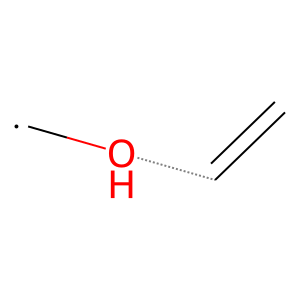

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [3]:
trans_smiles = trans_smiles.replace("/", "~")
allxyz_paths = [
    path
    for path in Path(
        f"/home/tns97255/C5O-Kinetics/calc/{folder_name}/Optimization/run/REVDSD/"
    ).rglob("REVDSD.xyz")
]
if len(allxyz_paths) > 1:
    raise ValueError(
        f"Multiple XTB.allxyz files found in {Path(f'/home/tns97255/C5O-Kinetics/calc/{folder_name}/Optimization/')}. Please check the directory."
    )
else:
    inter_xyz = Path(allxyz_paths[0])

visualize_smiles(trans_smiles)
labelled_3d_structure(inter_xyz)


In [130]:
scan_coordinates = "B" + " " + "1 2"  # geom scan coordinates
charge = 0
multiplicity = 2  # 1 if neutral, 2+ if radical
min_scan_dist = 0.1  # minimum distance for scan
max_scan_dist = 1.6  # maximum distance for scan

### Generate the scan .inp file

In [131]:
mol = Chem.MolFromXYZFile(str(inter_xyz))
_, a1, a2 = scan_coordinates.split(" ")
idx1 = int(a1)
idx2 = int(a2)

n_steps = abs(max_scan_dist - min_scan_dist) // 0.05 + 1

# --- Get 3D coordinates
with open(inter_xyz) as f:
    lines = f.readlines()
coords = []
for line in lines[2:]:  # skip first two lines of xyz
    parts = line.split()
    if len(parts) >= 4:
        coords.append([float(parts[1]), float(parts[2]), float(parts[3])])
coords = np.array(coords)
bond_len = np.linalg.norm(coords[idx1, :] - coords[idx2, :])

rxn_coordinates = (
    scan_coordinates
    + f" = {(bond_len + min_scan_dist):.2f}, {(bond_len + max_scan_dist):.2f}, {n_steps}\n"
)
print(rxn_coordinates)
write_scan(
    intermediate_xyz=str(inter_xyz),
    trans_smiles=trans_smiles,
    scan_coordinates=scan_coordinates,
    rxn_coordinates=rxn_coordinates,
    charge=charge,
    multiplicity=multiplicity,
)

B 1 2 = 1.47, 2.97, 30.0

pixi run run_scan /home/tns97255/C5O-Kinetics/calc/_CH2_OCdblC/B_1_2/run/REVDSD_Scan


## Visualize to determine which transition structure is highest energy

In [126]:
max_step = 10
xyz_path = Path("/home/tns97255/C5O-Kinetics/calc/_CH2_OCdblC/B_1_2")

In [127]:
try:
    work_dir = xyz_path / "run/REVDSD_Scan/"
except TypeError:
    par_dir = Path(str(inter_xyz).split("Optimization")[0])
    work_dir = par_dir / f"{scan_coordinates.replace(' ', '_')}/run/REVDSD_Scan/"
allxyz_paths = [path for path in work_dir.rglob("REVDSD.allxyz")]
if len(allxyz_paths) > 1:
    raise ValueError(
        f"Multiple XTB.allxyz files found in {work_dir}. Please check the directory."
    )
else:
    allxyz_path = allxyz_paths[0]

comment = pp.Group(
    pp.Keyword("Scan Step")
    + ppc.integer("index")
    + pp.Keyword("E")
    + ppc.fnumber("energy")
)
expr = pp.OneOrMore(pp.SkipTo(comment, include=True))
text = re.sub(">\n", "", allxyz_path.read_text())

indices = []
energies = []
results = expr.parse_string(text)
for result in results[1::2]:
    index, energy = result[1:4:2]
    indices.append(index)
    energies.append(energy)

df = pd.DataFrame(
    {
        "index": indices,
        "energy": energies,
    }
)

print("Plot of energy vs. index")
alt.Chart(df).mark_point().encode(
    x="index",
    y=alt.Y("energy", scale=alt.Scale(zero=False)),
).show()

if max_step is None:
    max_step = df["index"][df["energy"].idxmax()]

print(f"Maximum energy step: {max_step}")

max_scan_xyz_path = glob.glob(str(allxyz_path.parent / f"REVDSD.*{max_step:03d}.xyz"))[
    0
]

xyz = Chem.MolToXYZBlock(Chem.MolFromXYZFile(max_scan_xyz_path))
smiles = Chem.MolToSmiles(Chem.MolFromXYZBlock(xyz))

natoms = int(allxyz_path.read_text().split()[0])

viewer = py3Dmol.view()
viewer.addModel(xyz, "xyz")
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.3}})

for i in range(natoms):
    viewer.addLabel(
        i,
        {
            "backgroundOpacity": 0,
            "fontColor": "blue",
            "alignment": "center",
            "inFront": True,
        },
        {"index": i},
    )

viewer.zoomTo()
print(f"Visualization of the highest energy structure (index {max_step})")
viewer.show()

### Automatically find the path to the scan coordinates

Plot of energy vs. index


alt.Chart(...)

Maximum energy step: 10
Visualization of the highest energy structure (index 10)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Write the optimization files

In [43]:
write_opt(
    transition_xyz=max_scan_xyz_path,
    trans_smiles=trans_smiles,
    charge=charge,
    multiplicity=multiplicity,
)

bash /home/tns97255/C5O-Kinetics/calc/_CH2_CCC1CO1/B_1_2/run/submit_opt.sh


### Visualize the imaginary vibrational mode

In [109]:
xyz_path = "/home/tns97255/C5O-Kinetics/calc/_CH2_C1CO1/B_1_2/run/REVDSD/40244004/REVDSD.log.v006.xyz"

In [ ]:
animate_xyz(xyz_path)

IsADirectoryError: [Errno 21] Is a directory: '/home/tns97255/C5O-Kinetics/calc/_CH2_OCdblC/B_1_2'